<a href="https://colab.research.google.com/github/inConsciousness/Tumor_detection_ML_Model/blob/main/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#checkpoint code
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
import dill

# Save the entire environment
with open('/content/drive/MyDrive/colab_workspace.pkl', 'wb') as f:
    dill.dump_session(f)

In [ ]:
# Backup the notebook by appending "_backup" to the filename
!cp "/content/drive/MyDrive/AI_Projects/Grading_Tumors/notebooks/project_notebook.ipynb" \
"/content/drive/MyDrive/AI_Projects/Grading_Tumors/notebooks/project_notebook_backup.ipynb"


In [ ]:
# Ensure GPU runtime in Colab
import tensorflow as tf

# Print available devices and check for GPU
print("Available devices:", tf.config.list_physical_devices())
print("GPU available:", tf.config.list_physical_devices('GPU'))

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns


In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload Kaggle API credentials
from google.colab import files
files.upload()  # Upload kaggle.json

# Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation
!unzip -o brain-tumor-image-dataset-semantic-segmentation.zip -d ./dataset/

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Download the Flickr8k Dataset using Kaggle API
!kaggle datasets download -d adityajn105/flickr8k

# Unzip the dataset into a folder named 'flickr8k_dataset'
!unzip -o flickr8k.zip -d ./flickr8k_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: ./flickr8k_dataset/Images/2844846111_8c1cbfc75d.jpg  
  inflating: ./flickr8k_dataset/Images/2844963839_ff09cdb81f.jpg  
  inflating: ./flickr8k_dataset/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: ./flickr8k_dataset/Images/2845691057_d4ab89d889.jpg  
  inflating: ./flickr8k_dataset/Images/2845845721_d0bc113ff7.jpg  
  inflating: ./flickr8k_dataset/Images/2846037553_1a1de50709.jpg  
  inflating: ./flickr8k_dataset/Images/2846785268_904c5fcf9f.jpg  
  inflating: ./flickr8k_dataset/Images/2846843520_b0e6211478.jpg  
  inflating: ./flickr8k_dataset/Images/2847514745_9a35493023.jpg  
  inflating: ./flickr8k_dataset/Images/2847615962_c330bded6e.jpg  
  inflating: ./flickr8k_dataset/Images/2847859796_4d9cb0d31f.jpg  
  inflating: ./flickr8k_dataset/Images/2848266893_9693c66275.jpg  
  inflating: ./flickr8k_dataset/Images/2848571082_26454cb981.jpg  
  inflating: ./flickr8k_dataset/Images/2848895544_6d06210e9d.jpg  
  inflating

In [ ]:
# Define dataset path
dataset_path = './dataset/'

# Verify folders
for folder in ['train', 'test', 'valid']:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Subfolder not found: {folder_path}")
    print(f"\nContents of {folder}:")
    print(os.listdir(folder_path)[:5])  # Display first 5 files


Contents of train:
['1747_jpg.rf.bc556c5ea46dc28792d934d14cd81a55.jpg', '2842_jpg.rf.efa0c72cda7c8948aea33e213960bdfd.jpg', '1557_jpg.rf.48b353750d4a42ce2a9baffdb6680191.jpg', '1962_jpg.rf.90ec11ae340d7c02247e681b1e1a77dc.jpg', '2929_jpg.rf.aef8778dc395eb560b70111d69a77330.jpg']

Contents of test:
['2622_jpg.rf.9a2b253d3df53f5a372ed7a474686412.jpg', '2769_jpg.rf.877b956608e3dbe58e8ad6d544bc11e9.jpg', '2003_jpg.rf.6b8ef47cbc147415c9ceb58526380608.jpg', '214_jpg.rf.28a9bdc47bd9a90f3b7981b25d7b4380.jpg', '1529_jpg.rf.b831bbb2494fc637c3e2bee51f90307e.jpg']

Contents of valid:
['1045_jpg.rf.1f59bdc2ecb73fda52446ac8f7fa4a30.jpg', '1234_jpg.rf.38422a8518c33ca609f223d0d4115f0d.jpg', '2137_jpg.rf.c22fdb5669c5e11b105ca4644a6b9e2f.jpg', '1412_jpg.rf.881216992386406a751221f5fd4d5cd2.jpg', '1907_jpg.rf.ade7ad5136f190224b9871ee0724baf0.jpg']


In [ ]:
import cv2
from tensorflow.keras.utils import to_categorical
def load_images_and_labels(folder, target_size=(128, 128)):
    """
    Loads images and assigns random labels for binary classification.
    Args:
        folder (str): Path to the folder (e.g., 'train', 'test', 'valid').
        target_size (tuple): Image size to resize to.

    Returns:
        tuple: (images, labels)
    """
    images = []
    labels = []
    for file in sorted(os.listdir(folder)):
        if file.endswith('.jpg'):  # Ensure only .jpg files are processed
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            images.append(img / 255.0)  # Normalize image
            labels.append(np.random.randint(0, 2))  # Random binary label
    return np.array(images), np.array(labels)

# Load train, test, and valid data
X_train, y_train = load_images_and_labels(os.path.join(dataset_path, 'train'))
X_test, y_test = load_images_and_labels(os.path.join(dataset_path, 'test'))
X_valid, y_valid = load_images_and_labels(os.path.join(dataset_path, 'valid'))

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")

X_train shape: (1502, 128, 128, 3), y_train shape: (1502, 2)
X_test shape: (215, 128, 128, 3), y_test shape: (215, 2)
X_valid shape: (429, 128, 128, 3), y_valid shape: (429, 2)


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the hypermodel
def build_hypermodel(hp):
    inputs = Input((128, 128, 3))  # Define input shape
    x = Conv2D(hp.Int('filters', 32, 96, step=32), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('filters_2', 32, 128, step=32), (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(hp.Choice('dropout_rate', [0.3, 0.5]))(x)
    x = Flatten()(x)
    x = Dense(hp.Int('dense_units', 128, 256, step=64), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(hp.Choice('dropout_dense', [0.3, 0.5]))(x)
    outputs = Dense(2, activation='softmax')(x)  # Define output layer
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Import Keras Tuner
import keras_tuner as kt

# Set up the tuner
tuner = kt.Hyperband(
    build_hypermodel,                     # Hypermodel function
    objective='val_accuracy',             # Optimization goal
    max_epochs=10,                        # Maximum number of epochs per trial
    factor=3,                             # Reduction factor for Hyperband
    directory='tuner_results',            # Directory to save tuning results
    project_name='cnn_tuning'             # Project name for organization
)

# Start the hyperparameter search
tuner.search(
    X_train,                              # Training data
    y_train,                              # Training labels
    validation_data=(X_valid, y_valid),   # Validation data and labels
    batch_size=8,                         # Reduce batch size to prevent memory issues
    epochs=20                             # Total number of epochs for tuning
)

# Retrieve and print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 30 Complete [00h 00m 31s]
val_accuracy: 0.5314685106277466

Best val_accuracy So Far: 0.5524475574493408
Total elapsed time: 00h 08m 26s
Best hyperparameters: {'filters': 32, 'filters_2': 96, 'dropout_rate': 0.5, 'dense_units': 256, 'dropout_dense': 0.3, 'learning_rate': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [ ]:
import os
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure checkpoint directory exists
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Build model with best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Define checkpoint path

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Train the model
history = final_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=callbacks
)

# Save the model and training history
final_model.save('final_cnn_model.h5')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model and training history have been saved successfully!")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.5006 - loss: 1.1770 - val_accuracy: 0.4918 - val_loss: 0.9777 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5004 - loss: 0.9540 - val_accuracy: 0.4942 - val_loss: 0.9016 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4881 - loss: 0.8902 - val_accuracy: 0.4942 - val_loss: 0.8559 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4719 - loss: 0.8486 - val_accuracy: 0.4825 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5049 - loss: 0.8190 - val_accuracy: 0.4918 - val_loss: 0.8057 - learning_rate: 1.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4837 - loss: 0.8008 - val_accuracy: 0.4965 - val_loss: 0.7886 - learning_rate: 1.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5157 - loss: 0

Model and training history have been saved successfully!


In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load best hyperparameters

# Rebuild the model using the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Load the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint('/content/checkpoints/')
if latest_checkpoint:
    print(f"Restoring weights from checkpoint: {latest_checkpoint}")
    final_model.load_weights(latest_checkpoint)
else:
    print("No checkpoint found. Starting training from scratch.")

# Ensure data augmentation is properly initialized
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Resume training with existing or new callbacks
history = final_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=callbacks
)

# Save the updated model and training history
final_model.save('final_cnn_model_updated.h5')
print("Model saved as 'final_cnn_model_updated.h5'")

with open('training_history_updated.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Updated training history saved as 'training_history_updated.pkl'")

No checkpoint found. Starting training from scratch.
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.4997 - loss: 1.1738 - val_accuracy: 0.5152 - val_loss: 0.9514 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4859 - loss: 0.9347 - val_accuracy: 0.4895 - val_loss: 0.8897 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5069 - loss: 0.8796 - val_accuracy: 0.4988 - val_loss: 0.8519 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4907 - loss: 0.8446 - val_accuracy: 0.4965 - val_loss: 0.8256 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5156 - loss: 0.8205 - val_accuracy: 0.4848 - val_loss: 0.8063 - learning_rate: 1.0000e-04


Model saved as 'final_cnn_model_updated.h5'
Updated training history saved as 'training_history_updated.pkl'


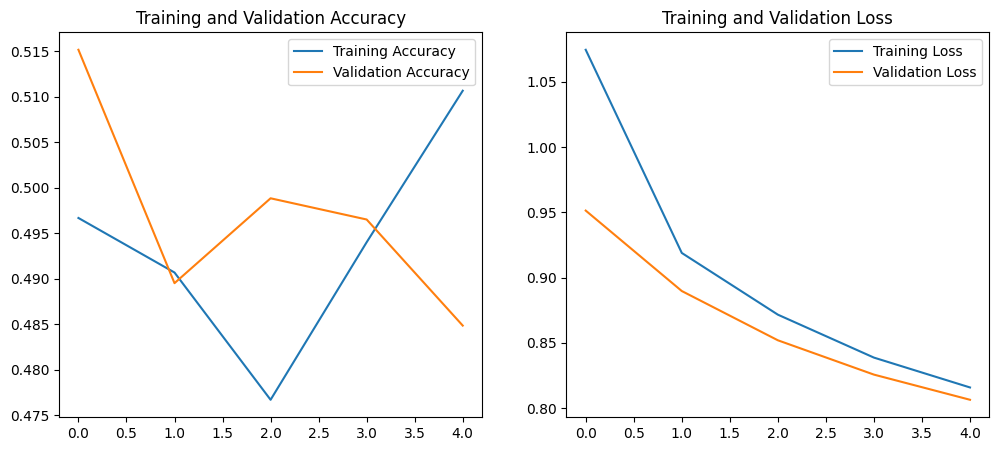

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """
    Plots training and validation accuracy and loss.
    """
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Train the model and plot learning curves
plot_learning_curves(history)


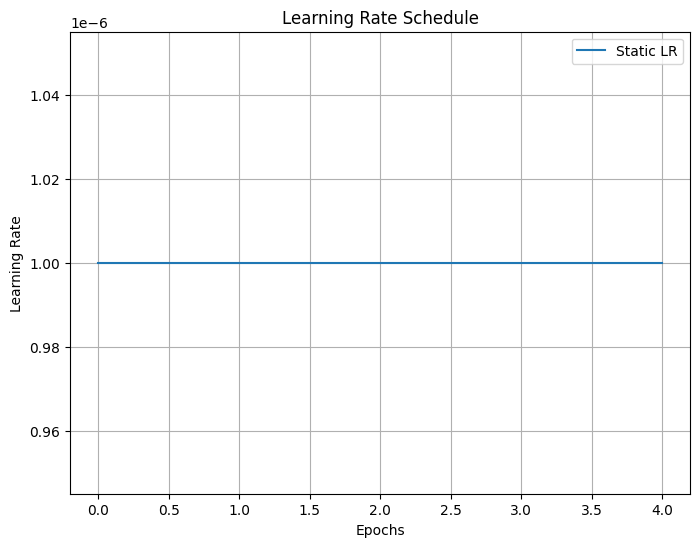

In [ ]:
def plot_learning_rate(history):
    """
    Plots the changes in learning rate during training.
    """
    # Access learning rate from the optimizer through the history object
    lrs = history.history.get('lr', [])  # Learning rate changes (if tracked in history)
    epochs = range(len(history.history['accuracy']))  # Number of epochs

    plt.figure(figsize=(8, 6))
    if lrs:
        plt.plot(epochs, lrs, label="Learning Rate")
    else:
        plt.plot(epochs, [reduce_lr.min_lr] * len(epochs), label="Static LR")  # Default if not available
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.show()

# Ensure you include the `learning rate` in your callback tracking or optimizer
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


# Plot learning rate schedule
plot_learning_rate(history)


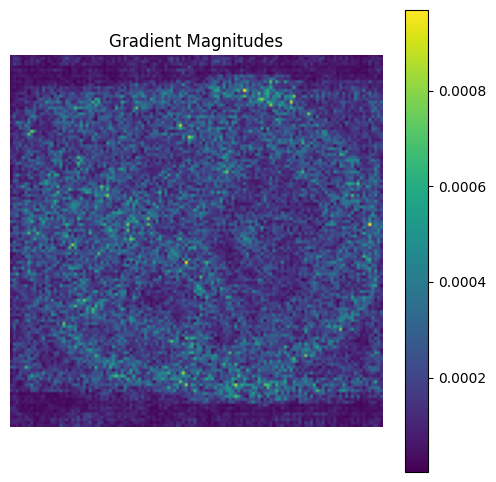

In [ ]:
import tensorflow as tf

def visualize_gradients(model, X_sample, y_sample):
    """
    Visualizes the gradients for a given model and sample input data.
    """
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(X_sample, dtype=tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.keras.losses.CategoricalCrossentropy()(y_sample, predictions)

    gradients = tape.gradient(loss, inputs)

    # Plot the gradients
    plt.figure(figsize=(6, 6))
    plt.title("Gradient Magnitudes")
    plt.imshow(tf.reduce_mean(tf.abs(gradients), axis=-1)[0], cmap='viridis')
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Example usage: Visualize gradients on a test sample
X_sample = X_test[:1]
y_sample = y_test[:1]
visualize_gradients(final_model, X_sample, y_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


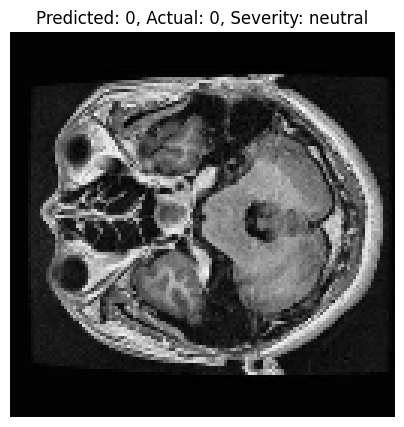

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


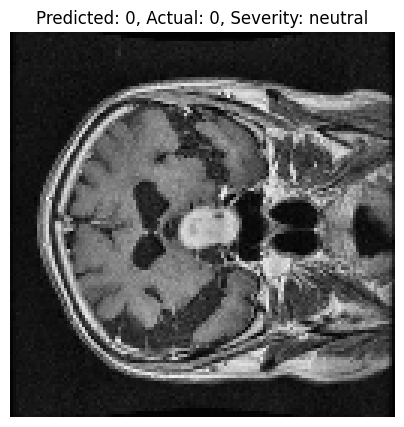

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


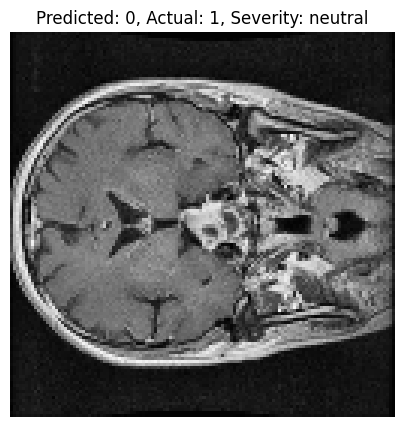

In [ ]:
def grade_severity(predictions, thresholds=[0.2, 0.4, 0.6, 0.8]):
    """
    Assigns severity levels based on prediction probabilities.
    """
    severity_levels = []
    for prob in predictions:
        if prob < thresholds[0]:
            severity_levels.append('mild')
        elif prob < thresholds[1]:
            severity_levels.append('low')
        elif prob < thresholds[2]:
            severity_levels.append('neutral')
        elif prob < thresholds[3]:
            severity_levels.append('significant')
        else:
            severity_levels.append('extreme')
    return severity_levels

def visualize_predictions_with_severity_levels(model, images, labels, thresholds=[0.2, 0.4, 0.6, 0.8], num_samples=3):
    for i in range(num_samples):
        pred = model.predict(images[i:i+1])[0]
        pred_class = np.argmax(pred)
        true_class = np.argmax(labels[i])
        severity_level = grade_severity([pred[pred_class]], thresholds)[0]

        plt.figure(figsize=(5, 5))
        plt.title(f"Predicted: {pred_class}, Actual: {true_class}, Severity: {severity_level}")
        plt.imshow(images[i])
        plt.axis('off')
        plt.show()

# Visualize predictions with severity levels
visualize_predictions_with_severity_levels(final_model, X_test, y_test, thresholds=[0.2, 0.4, 0.6, 0.8], num_samples=3)

In [ ]:
from typing import final
final_model.save('saved_model.keras')  # Added .keras extension

# Save the model in HDF5 format
final_model.save('cnn_model.h5')  # Automatically saves as HDF5

# Save the model to Google Drive (optional for Colab users)
!cp cnn_model.h5 /content/drive/MyDrive/
!cp -r saved_model.keras /content/drive/MyDrive/ # Updated path to include .keras

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step


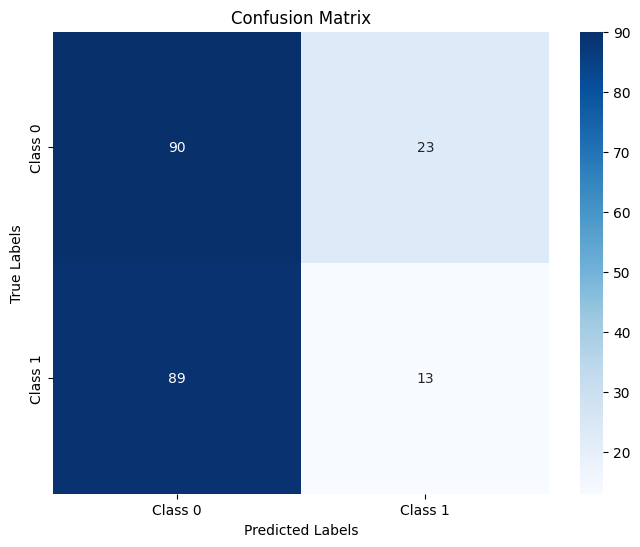

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.50      0.80      0.62       113
     Class 1       0.36      0.13      0.19       102

    accuracy                           0.48       215
   macro avg       0.43      0.46      0.40       215
weighted avg       0.44      0.48      0.41       215



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test data
y_pred_probs = final_model.predict(X_test)  # Get prediction probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n")
print(class_report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


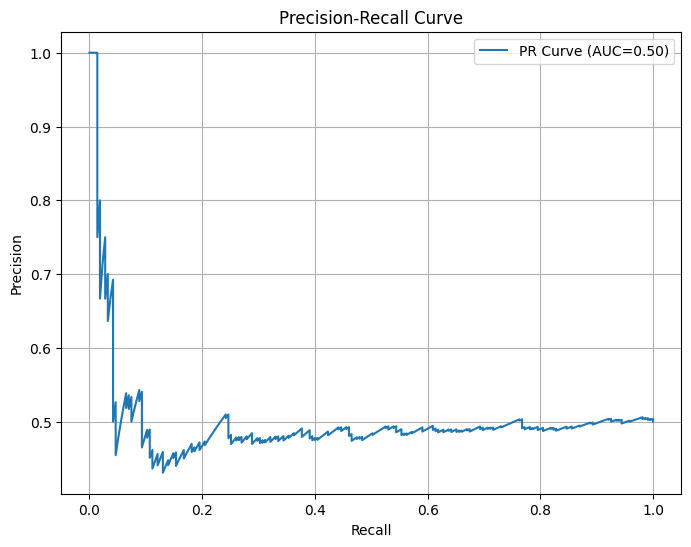

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Get precision-recall curve data
y_pred_probs = final_model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


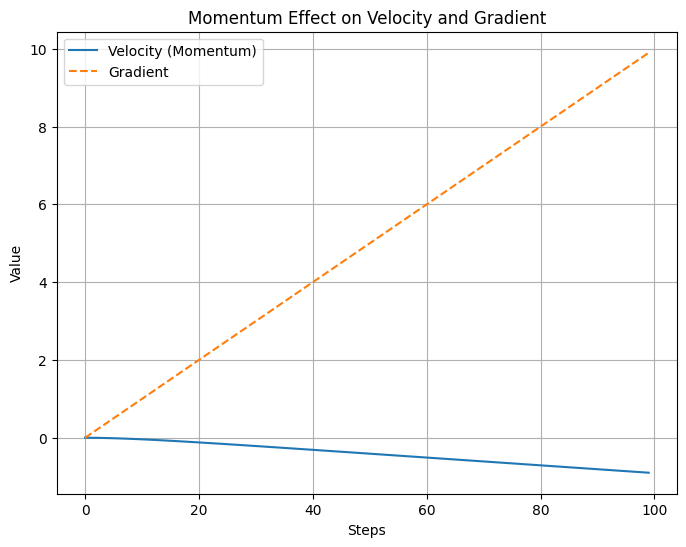

In [ ]:
def plot_momentum(learning_rate=0.01, momentum=0.9, num_steps=100):
    """
    Simulates and plots momentum updates for a simple example.
    """
    velocities = []
    gradients = []
    velocity = 0

    for step in range(num_steps):
        grad = step / 10.0  # Simulated gradient
        gradients.append(grad)
        velocity = momentum * velocity - learning_rate * grad
        velocities.append(velocity)

    # Plot velocity and gradient
    plt.figure(figsize=(8, 6))
    plt.plot(range(num_steps), velocities, label='Velocity (Momentum)')
    plt.plot(range(num_steps), gradients, label='Gradient', linestyle='--')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('Momentum Effect on Velocity and Gradient')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Momentum
plot_momentum(learning_rate=0.01, momentum=0.9, num_steps=100)

In [ ]:
# Install the Hugging Face Hub library
!pip install huggingface_hub

# Login to Hugging Face
from huggingface_hub import notebook_login
notebook_login()  # This will prompt you to enter your Hugging Face token

In [ ]:
!ls


brain-tumor-image-dataset-semantic-segmentation.zip  final_cnn_model_updated.h5
checkpoints					     sample_data
cnn_model.h5					     saved_model.keras
dataset						     training_history.pkl
drive						     training_history_updated.pkl
final_cnn_model.h5				     tuner_results


In [ ]:
from huggingface_hub import HfApi, notebook_login
import os

# Save the final model in Keras format
final_model.save('final_model.keras')
print("Model saved as 'final_model.keras'.")

# Hugging Face Login (if not already logged in)
notebook_login()  # This will prompt you to enter your Hugging Face token

# Repository details
repo_name = "Tumor_detection_ML_Model"  # Replace with your desired repository name
username = "Srivardhan369"  # Replace with your Hugging Face username
repo_id = f"{username}/{repo_name}"

# Initialize Hugging Face API
api = HfApi()

# Check if the repository already exists
try:
    api.create_repo(repo_id=repo_id, repo_type="model", private=False)
    print(f"Repository {repo_id} created successfully.")
except Exception as e:
    print(f"Repository {repo_id} already exists or could not be created: {e}")

# Check if the model file exists in the specified folder
model_file_path = "final_model.keras"  # Ensure correct path
if not os.path.exists(model_file_path):
    raise FileNotFoundError(f"Model file not found at {model_file_path}")

# Push the model to Hugging Face
try:
    api.upload_file(
        path_or_fileobj=model_file_path,  # Path to the local model file
        path_in_repo="final_model.keras",  # Path where the file will be stored in the Hugging Face repo
        repo_id=repo_id,
        repo_type="model"
    )
    print(f"Model uploaded successfully to Hugging Face: https://huggingface.co/{repo_id}")
except Exception as upload_error:
    print(f"Error uploading the model: {upload_error}")


Model saved as 'final_model.keras'.


Repository Srivardhan369/Tumor_detection_ML_Model already exists or could not be created: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-678b61bb-3fac6f1066aadbb5673d4fd2;30c34632-a105-46a3-921a-7e67319fa75e)

You already created this model repo


final_model.keras:   0%|          | 0.00/302M [00:00<?, ?B/s]

Model uploaded successfully to Hugging Face: https://huggingface.co/Srivardhan369/Tumor_detection_ML_Model
